In [1]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem
from many_stop_words import get_stop_words
import gensim
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
%matplotlib inline

ru_stopwords = get_stop_words('ru')

In [2]:
df = pd.read_csv('data/judicial_orders_lemmas.csv') # Параллельный корпус (текст-статьи)
code = pd.read_csv('data/criminal_code.csv') # УК РФ
dictionary = gensim.corpora.Dictionary.load('data/opencorpora/opencorpora.dict') # Известные слова русского языка (из opencorpora)

In [3]:
df['lemmas'] = df['lemmas'].map(eval)
code['lemmas'] = code['lemmas'].map(eval)

In [4]:
code['bow'] = code['lemmas'].map(dictionary.doc2bow)
df['bow'] = df['lemmas'].map(dictionary.doc2bow)

In [5]:
tf_idf = gensim.models.TfidfModel.load('data/opencorpora/tfidf/opencorpora_tfidf.model')

In [6]:
def map_vector(vector, size):
    a = np.zeros(size)
    for n, value in vector:
        a[n] = value
    return a

In [7]:
size = len(dictionary)
code['tfidf'] = code['bow'].map(lambda bow: map_vector(tf_idf[bow], size))
df['tfidf'] = df['bow'].map(lambda bow: map_vector(tf_idf[bow], size))

Расстояния между каждым делом и каждой статьёй УК РФ:

In [8]:
def measure_distances(vec, distance):
    return code['tfidf'].map(lambda x: distance(vec, x)).tolist()

from scipy.spatial.distance import cosine
df['distances'] = df['tfidf'].map(lambda vec: measure_distances(vec, cosine))

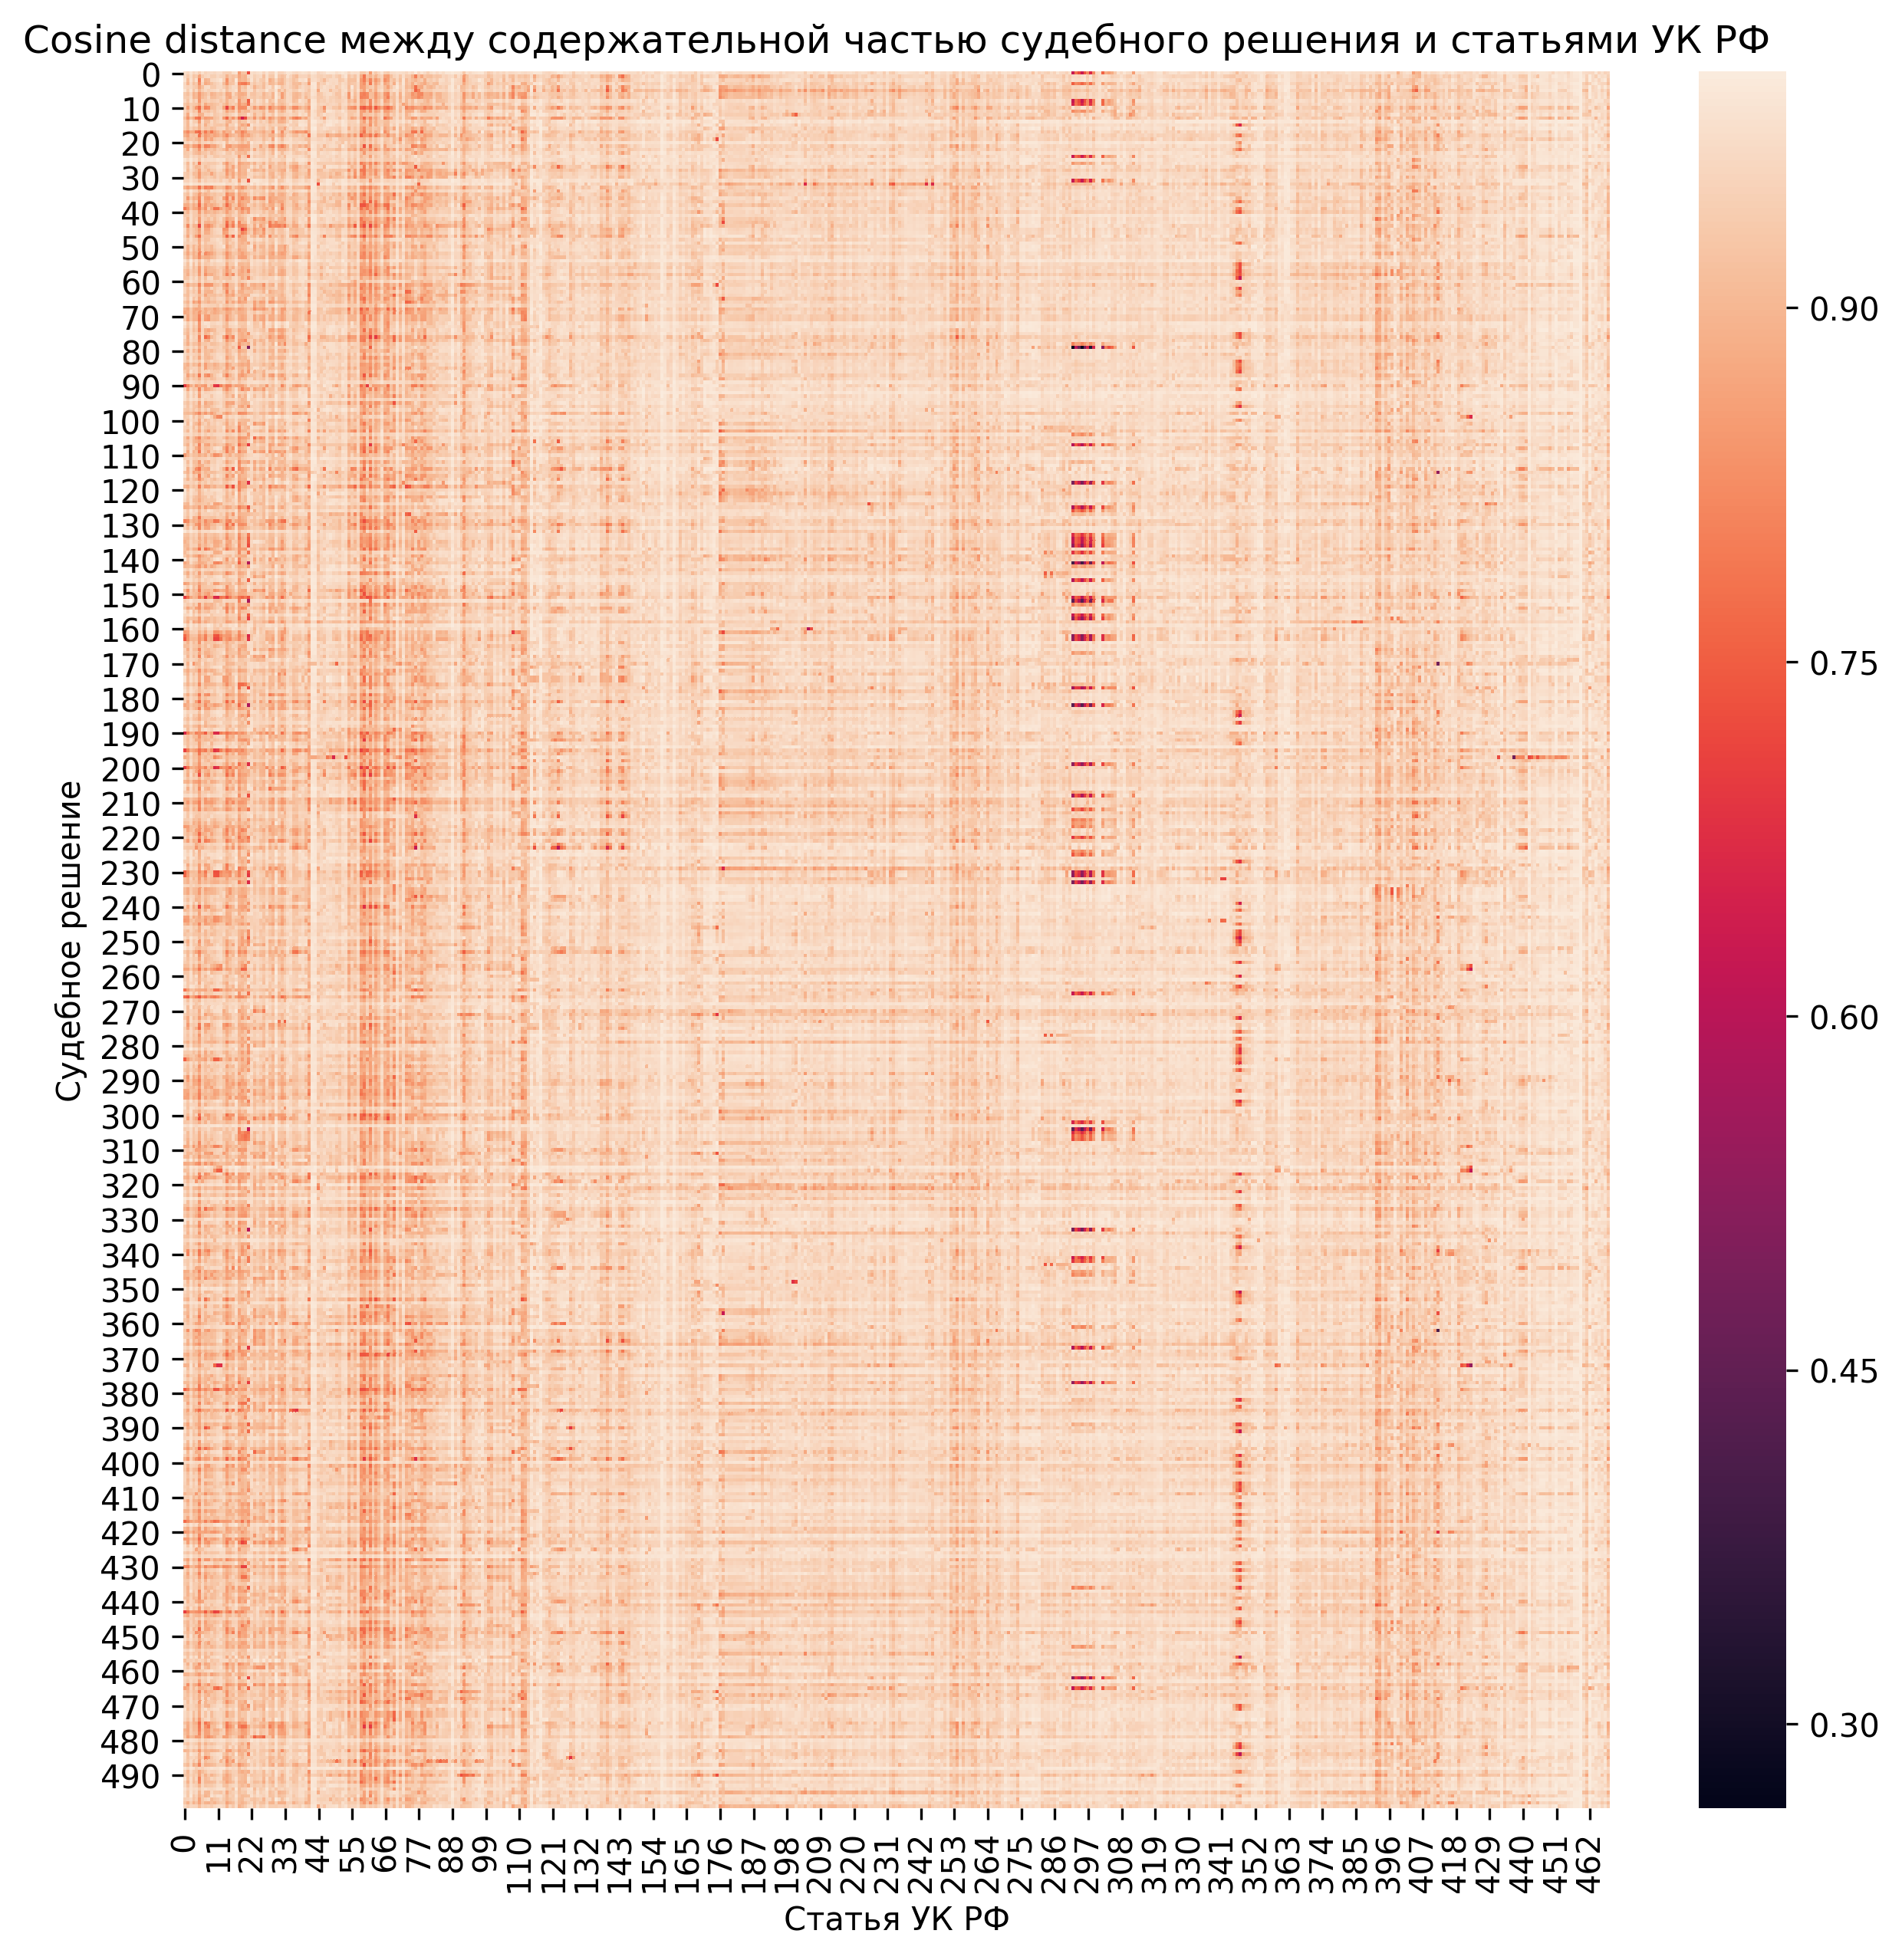

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=300)
_ = sns.heatmap(df[:500]['distances'].tolist(), ax=ax)
ax.set_title('Cosine distance между содержательной частью судебного решения и статьями УК РФ')
ax.set_ylabel('Судебное решение')
ax.set_xlabel('Статья УК РФ')
pass

Аномально близкие ко многим делам статьи:

In [84]:
top_numbers = df['distances'].map(np.argmin).value_counts()[:5]

In [107]:
[print('Кол-во: {}/{} \t Ст.{} - {}'.format(v, df.shape[0], code.loc[k,'number'], code.loc[k, 'name'])) 
for k, v in top_numbers.iteritems()]
pass

Кол-во: 1283/9533 	 Ст.264.1 - Нарушение правил дорожного движения лицом, подвергнутым административному наказанию
Кол-во: 1248/9533 	 Ст.61.0 - Обстоятельства, смягчающие наказание
Кол-во: 864/9533 	 Ст.228.0 - Незаконные приобретение, хранение, перевозка, изготовление, переработка наркотических средств, психотропных веществ или их аналогов, а также незаконные приобретение, хранение, перевозка растений, содержащих наркотические средства или психотропные вещества, либо их частей, содержащих наркотические средства или психотропные вещества
Кол-во: 442/9533 	 Ст.6.0 - Принцип справедливости
Кол-во: 402/9533 	 Ст.63.0 - Обстоятельства, отягчающие наказание


Группируем статьи по расстояниям:

In [17]:
from collections import defaultdict
def group_by_dist(numbers, distances):
    v = defaultdict(list)
    for number, distance in zip(numbers, distances):
        v[round(distance, 2)].append(number)
    return v

In [20]:
df['grouped_distances'] = df['distances'].map(lambda distances: group_by_dist(code['number'].tolist(), distances))

In [112]:
df['nearest'] = df['distances'].map(lambda x: code.loc[np.argmin(x), 'number'])

In [116]:
df['labels'] = df['labels'].map(eval)

Доля попаданий в статьи, указанные судьёй

In [120]:
df.apply(lambda row: row['nearest'] in row['labels'], axis=1).astype(int).sum() / df.shape[0]

0.3512010909472359